# Desenvolvimento de Modelo (Gestock):

Pré-requisito: 
- Python 3.13.5
- Biblioteca KaggleAPI baixada para utilizar os datasets.
- Chave de API própria adquirida com ```Kaggle.json```

---
**Etapas para Download:**

1. Criar conta no Kaggle (caso não tenha);
2. Acessar seu User Profile, ir em Settings e procurar "Legacy API Credentials". Isso irá baixar "Kaggle.json";
3. Mover este arquivo JSON para ```C:\Users\<Windows-username>\.kaggle\``` (caso a pasta .kaggle não exista, basta criá-la);
4. Baixar biblioteca Kaggle. ```pip install kaggle```.
---

Rodar os scripts a seguir vai baixar todo o dataset do M5 Forecasting.

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors
import os
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi

In [ ]:
#  Baixar datasets do M5. Pode demorar, a depender da internet.

DATA_DIR = r"../Data"
COMPETITION = "m5-forecasting-accuracy"

os.makedirs(DATA_DIR, exist_ok=True)

api = KaggleApi()
api.authenticate()

api.competition_download_files(
    COMPETITION,
    path=DATA_DIR,
    quiet=False
    )

zip_path = os.path.join(DATA_DIR, f"{COMPETITION}.zip")

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(DATA_DIR)

os.remove(zip_path)

100%|██████████| 45.8M/45.8M [00:02<00:00, 19.8MB/s]


In [3]:
calendarioSazonal = pd.read_csv(r'../Data/calendar.csv').drop(columns=['snap_TX', 'snap_WI', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'weekday'])
calendarioSazonal = calendarioSazonal[:1913] #  Limitando o calendário ao mesmo número de dias que o dataset de vendas
calendarioSazonal

,date,wm_yr_wk,wday,month,year,d,snap_CA
0,2011-01-29,11101,1,1,2011,d_1,0
1,2011-01-30,11101,2,1,2011,d_2,0
2,2011-01-31,11101,3,1,2011,d_3,0
3,2011-02-01,11101,4,2,2011,d_4,1
4,2011-02-02,11101,5,2,2011,d_5,1
...,...,...,...,...,...,...,...
1908,2016-04-20,11612,5,4,2016,d_1909,0
1909,2016-04-21,11612,6,4,2016,d_1910,0
1910,2016-04-22,11612,7,4,2016,d_1911,0
1911,2016-04-23,11613,1,4,2016,d_1912,0


In [4]:
vendasTrain = pd.read_csv(r'../Data/sales_train_validation.csv')
vendasTrain #  Cada linha consiste em um produto em uma loja. São 3049 produtos em 10 lojas diferentes para 1941 dias.

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [5]:
sellPrices = pd.read_csv(r'../Data/sell_prices.csv')
sellPrices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [6]:
print(calendarioSazonal.isna().sum())
calendarioSazonal.info()

date        0
wm_yr_wk    0
wday        0
month       0
year        0
d           0
snap_CA     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1913 non-null   object
 1   wm_yr_wk  1913 non-null   int64 
 2   wday      1913 non-null   int64 
 3   month     1913 non-null   int64 
 4   year      1913 non-null   int64 
 5   d         1913 non-null   object
 6   snap_CA   1913 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 104.7+ KB


In [7]:
print(vendasTrain.isna().sum())
vendasTrain.info()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1909      0
d_1910      0
d_1911      0
d_1912      0
d_1913      0
Length: 1919, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [8]:
print(sellPrices.isna().sum())
sellPrices.info()

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [9]:
wideSales = vendasTrain.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                          var_name='day')

In [10]:
wideSales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 8 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   id        object
 1   item_id   object
 2   dept_id   object
 3   cat_id    object
 4   store_id  object
 5   state_id  object
 6   day       object
 7   value     int64 
dtypes: int64(1), object(7)
memory usage: 3.5+ GB


In [ ]:
#  União do calendário sazonal com o preço dos produtos em cada dia. Pode demorar, por causa do tamanho do dataset.

wideSalesCalendar = wideSales.merge(
    calendarioSazonal,
    left_on='day',
    right_on='d',
    how='left'
).drop(columns='d')

In [ ]:
#  União da etapa anterior com as movimentações (vendas) de cada produto. Pode demorar, por causa do tamanho do dataset.

demandComplete = wideSalesCalendar.merge(sellPrices,left_on=['item_id','store_id','wm_yr_wk'], right_on=['item_id','store_id','wm_yr_wk'], how='left')

In [13]:
demandComplete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 15 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item_id     object 
 2   dept_id     object 
 3   cat_id      object 
 4   store_id    object 
 5   state_id    object 
 6   day         object 
 7   value       int64  
 8   date        object 
 9   wm_yr_wk    int64  
 10  wday        int64  
 11  month       int64  
 12  year        int64  
 13  snap_CA     int64  
 14  sell_price  float64
dtypes: float64(1), int64(6), object(8)
memory usage: 6.5+ GB


In [ ]:
#  Para fins de estudo, o modelo de Isolation Forest vai trabalhar com os 3049 produtos para uma única loja, ao invés de 10.

movimentacaoLojaCA_1 = demandComplete[demandComplete['store_id']=='CA_1'].copy()
movimentacaoLojaCA_1.isna().sum()

id                  0
item_id             0
dept_id             0
cat_id              0
store_id            0
state_id            0
day                 0
value               0
date                0
wm_yr_wk            0
wday                0
month               0
year                0
snap_CA             0
sell_price    1129842
dtype: int64

In [ ]:
#  Tratar valores NaN do dataset.

movimentacaoLojaCA_1['sell_price'] = (
    movimentacaoLojaCA_1
    .sort_values('day')
    .groupby('item_id')['sell_price']
    .bfill()
    .fillna(0) #  Caso ainda sobre valores NaN, considerar nulos.
)


In [19]:
movimentacaoLojaCA_1.isna().sum()

id            0
item_id       0
dept_id       0
cat_id        0
store_id      0
state_id      0
day           0
value         0
date          0
wm_yr_wk      0
wday          0
month         0
year          0
snap_CA       0
sell_price    0
dtype: int64

In [ ]:
feature_cols = [
    'value',
    'sell_price'
]

In [ ]:
#  Funções para cálculo do LOC e do ASS.

def local_density(X, k=10):
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X)
    distances, _ = nn.kneighbors(X)
    return 1 / (np.mean(distances, axis=1) + 1e-8)

def local_outlier_consistency(X, anomaly_flags, k=10):
    density = local_density(X, k)
    normal_density = density[anomaly_flags == 1]
    anomaly_density = density[anomaly_flags == -1]
    if len(anomaly_density) == 0:
        return np.nan
    return (normal_density.mean() - anomaly_density.mean()) / normal_density.std()

def anomaly_separation_score(X, anomaly_flags, k=10):
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X)
    distances, _ = nn.kneighbors(X)
    avg_dist = distances.mean(axis=1)
    normal_dist = avg_dist[anomaly_flags == 1]
    anomaly_dist = avg_dist[anomaly_flags == -1]
    if len(anomaly_dist) == 0:
        return np.nan
    return (anomaly_dist.mean() - normal_dist.mean()) / normal_dist.std()

In [ ]:
#  Isolation Forest para detectar anomalias por produto. Pode demorar de 10 a 20 minutos.

"""
Observações: é possível que apareçam os seguintes erros:

RuntimeWarning: divide by zero encountered in scalar divide
  return (normal_density.mean() - anomaly_density.mean()) / normal_density.std()

Isso não é problema nos algoritmos das métricas, mas trata-se especificamente do comportamento dos dados de alguns produtos, 
que não possui variação forte no preço nem em venda (desvio padrão muito baixo ou nulo), o que ocasiona a "divisão por zero".
"""

results = []
metrics = []

for item_id, group in movimentacaoLojaCA_1.groupby('item_id'):
    X = group[feature_cols]

    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    model = IsolationForest(
        n_estimators=100,
        contamination=0.01,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_scaled)

    group['anomaly_score'] = model.decision_function(X_scaled)
    group['anomaly'] = model.predict(X_scaled)

    loc = local_outlier_consistency(X_scaled, group['anomaly'].values, k=10)
    sep = anomaly_separation_score(X_scaled, group['anomaly'].values, k=10)

    metrics.append({
        'item_id': item_id,
        'LOC': loc,
        'Anomaly_Separation': sep
    })

    results.append(group)

metrics_df = pd.DataFrame(metrics) #  Salvar métricas calculadas em um dataframe separado para consulta futura.
metrics_df = metrics_df.set_index('item_id')

C:\Users\anton\AppData\Local\Temp\ipykernel_30980\1291201402.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  return (normal_density.mean() - anomaly_density.mean()) / normal_density.std()
C:\Users\anton\AppData\Local\Temp\ipykernel_30980\1291201402.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  return (anomaly_dist.mean() - normal_dist.mean()) / normal_dist.std()
C:\Users\anton\AppData\Local\Temp\ipykernel_30980\1291201402.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  return (normal_density.mean() - anomaly_density.mean()) / normal_density.std()
C:\Users\anton\AppData\Local\Temp\ipykernel_30980\1291201402.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  return (anomaly_dist.mean() - normal_dist.mean()) / normal_dist.std()
C:\Users\anton\AppData\Local\Temp\ipykernel_30980\1291201402.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  return (normal_density.mean() - anomaly_density.mean

In [ ]:
pd.concat(results).to_csv('../Data/movimentacaoLojaCA_1_anomalies.csv') #  Salvar o conteúdo, para não haver necessidade de ter que rodar o código inteiro de novo no futuro.

In [69]:
#movimentacaoLojaCA_1 = pd.read_csv('../Data/movimentacaoLojaCA_1_anomalies.csv').drop(columns='Unnamed: 0') #  Recuperar o dataset de onde parou.
movimentacaoLojaCA_1 = pd.concat(results)
movimentacaoLojaCA_1['date'] = pd.to_datetime(movimentacaoLojaCA_1['date'])

In [70]:
movimentacaoLojaCA_1

,id,item_id,dept_id,cat_id,store_id,state_id,day,value,date,wm_yr_wk,...,sell_price,lag_1,lag_2,lag_3,rolling_mean_7,rolling_mean_14,rolling_std_7,rolling_std_14,anomaly_score,anomaly
0,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,1,2011-02-01,11101,...,2.00,0.0,0.0,3.0,1.000000,1.000000,1.732051,1.732051,0.203211,1
1,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,5,4,2011-02-02,11101,...,2.00,1.0,0.0,0.0,1.000000,1.000000,1.414214,1.414214,0.049671,1
2,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,6,2,2011-02-03,11101,...,2.00,4.0,1.0,0.0,1.600000,1.600000,1.816590,1.816590,0.175738,1
3,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,7,0,2011-02-04,11101,...,2.00,2.0,4.0,1.0,1.666667,1.666667,1.632993,1.632993,0.229348,1
4,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,8,2,2011-02-05,11102,...,2.00,0.0,2.0,4.0,1.428571,1.428571,1.618347,1.618347,0.175738,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5823585,HOUSEHOLD_2_516_CA_1_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1909,0,2016-04-20,11612,...,5.94,0.0,0.0,0.0,0.285714,0.357143,0.487950,0.633324,0.322863,1
5823586,HOUSEHOLD_2_516_CA_1_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1910,1,2016-04-21,11612,...,5.94,0.0,0.0,0.0,0.285714,0.357143,0.487950,0.633324,0.217191,1
5823587,HOUSEHOLD_2_516_CA_1_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1911,1,2016-04-22,11612,...,5.94,1.0,0.0,0.0,0.285714,0.428571,0.487950,0.646206,0.217191,1
5823588,HOUSEHOLD_2_516_CA_1_validation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,1912,0,2016-04-23,11613,...,5.94,1.0,1.0,0.0,0.285714,0.357143,0.487950,0.497245,0.322863,1


In [71]:
movimentacaoLojaCA_1['dept_id'].value_counts()

dept_id
FOODS_3        1571930
HOUSEHOLD_1    1016120
HOUSEHOLD_2     983650
HOBBIES_1       794560
FOODS_2         760180
FOODS_1         412560
HOBBIES_2       284590
Name: count, dtype: int64

In [72]:
movimentacaoLojaCA_1['anomaly'].value_counts()

anomaly
 1    5776929
-1      46661
Name: count, dtype: int64

In [73]:
movimentacaoLojaCA_1.isna().sum()

id                 0
item_id            0
dept_id            0
cat_id             0
store_id           0
state_id           0
day                0
value              0
date               0
wm_yr_wk           0
wday               0
month              0
year               0
snap_CA            0
sell_price         0
lag_1              0
lag_2              0
lag_3              0
rolling_mean_7     0
rolling_mean_14    0
rolling_std_7      0
rolling_std_14     0
anomaly_score      0
anomaly            0
dtype: int64

In [76]:
metrics_df = metrics_df.set_index('item_id')

In [74]:
#  Função de plot dos resultados do Isolation Forest.

def plot_item_anomalies(
    df,
    item_id
):
    data = df[df['item_id'] == item_id].sort_values('date')

    plt.figure(figsize=(14, 5), facecolor='white')
    ax = plt.gca()
    ax.set_facecolor('white')

    # Série de demanda
    ax.plot(
        data['date'],
        data['value'],
        label='Demanda',
        linewidth=1,
        alpha=0.8
    )

    # Anomalias (Isolation Forest → -1)
    anomalies = data[data['anomaly'] == -1]
    
    ax.scatter(
        anomalies['date'],
        anomalies['value'],
        marker='x',
        s=60,
        label='Anomalia',
        zorder=5
    )

    # Formatação do eixo temporal
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    ax.set_title(f'Anomalias de Demanda | Loja CA_01 | {item_id}')
    ax.set_xlabel('Ano')
    ax.set_ylabel('Demanda')

    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


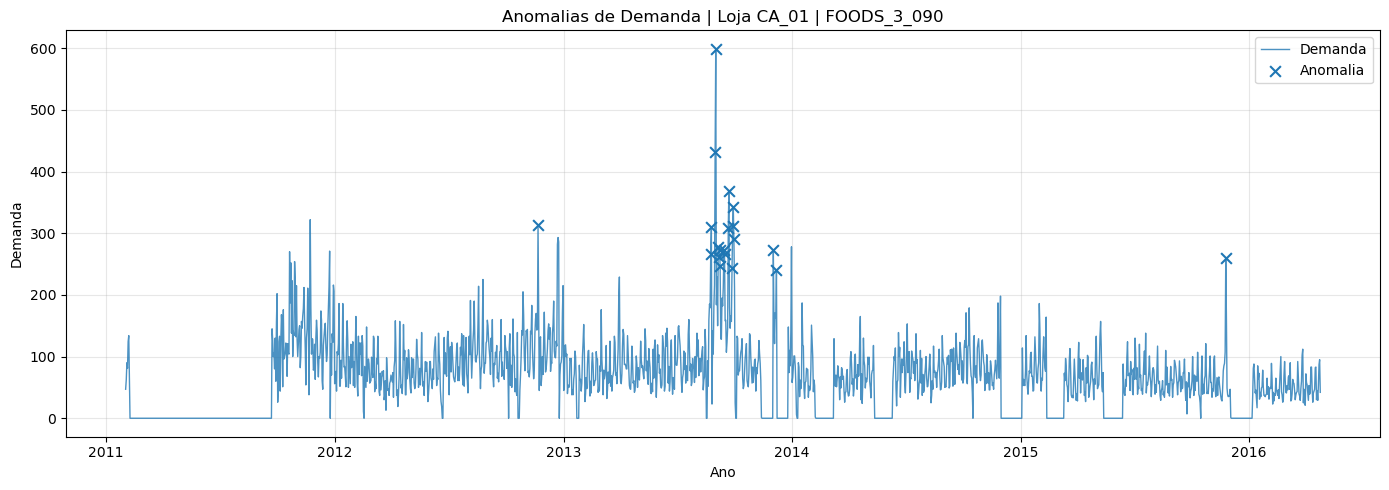

LOC (Local Outlier Consistency): 0.5630943674446415
ASS (Anomaly Separation Score): 10.29826608236588


In [ ]:
#  Plot.
plot_item_anomalies(
    movimentacaoLojaCA_1,
    item_id='HOBBIES_1_090'
)
#  Print das métricas
print(f'LOC (Local Outlier Consistency): {metrics_df.loc['HOBBIES_1_090']['LOC']}') #  Quanto maior for, maior a certeza de que o outlier é mesmo uma anomalia.
print(f'ASS (Anomaly Separation Score): {metrics_df.loc['HOBBIES_1_090']['Anomaly_Separation']}') #  Quanto maior for, indica que maior é o grau de separação de anomalias e pontos normais.

In [40]:
movimentacaoLojaCA_1[(movimentacaoLojaCA_1['anomaly']==-1) & (movimentacaoLojaCA_1['item_id']=='FOODS_3_090')]

,id,item_id,dept_id,cat_id,store_id,state_id,day,value,date,wm_yr_wk,...,sell_price,lag_1,lag_2,lag_3,rolling_mean_7,rolling_mean_14,rolling_std_7,rolling_std_14,anomaly_score,anomaly
1341756,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,940,310,2013-08-25,11331,...,1.0,266.0,179.0,185.0,133.428571,106.071429,90.400695,75.568068,-0.022580,-1
1341762,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,946,432,2013-08-31,11332,...,1.0,216.0,181.0,104.0,177.428571,136.428571,97.822726,96.118288,-0.046173,-1
1341763,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,947,599,2013-09-01,11332,...,1.0,432.0,216.0,181.0,201.142857,167.285714,135.671698,116.197066,-0.058494,-1
1341767,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,951,278,2013-09-05,11332,...,1.0,150.0,229.0,184.0,284.428571,228.571429,167.003849,143.269898,-0.004977,-1
1341783,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,967,309,2013-09-21,11335,...,1.0,147.0,123.0,107.0,176.000000,185.571429,66.257075,59.299389,-0.021903,-1
1341784,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,968,369,2013-09-22,11335,...,1.0,309.0,147.0,123.0,181.285714,188.142857,75.957695,63.978190,-0.038873,-1
1341790,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,974,312,2013-09-28,11336,...,1.0,243.0,157.0,166.0,224.285714,200.142857,86.104035,77.946586,-0.024140,-1
1341791,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,975,342,2013-09-29,11336,...,1.0,312.0,243.0,157.0,224.714286,203.000000,86.601991,81.438037,-0.034733,-1
1341792,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,976,290,2013-09-30,11336,...,1.0,342.0,312.0,243.0,220.857143,208.428571,79.407029,88.211908,-0.010787,-1
